In [1]:
# Topological Initialization for Multidimensional Scaling
# Melinda Kleczynski, Anthony J. Kearsley
# Finalized April 17, 2025 

# Data from: https://cave.cs.columbia.edu/repository/COIL-100

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random 

from PIL import Image
from scipy.spatial.distance import pdist, squareform 
from sklearn.decomposition import PCA 
from sklearn.manifold import MDS 

import timds 

In [3]:
def read_image(object_number, image_index):

    fpath = 'coil-100\\obj' + str(object_number) + '__' + str(5*image_index) + '.png'  
    image = np.asarray(Image.open(fpath))   

    return image/np.max(image) 

In [4]:
n_images = 72

In [5]:
# images ordered by ground truth angle; shuffle to hide ground truth 
shuffled_image_indices = [i for i in range(n_images)] 
random.seed(0) 
random.shuffle(shuffled_image_indices) 

In [6]:
init_names = ['Random 0', 'Random 1', 'Random 2', 'PCA', 'Topological']

In [7]:
examples = [[4, 'Tomato', 'euclidean'], 
            [29, 'Cat Food', 'cosine']]

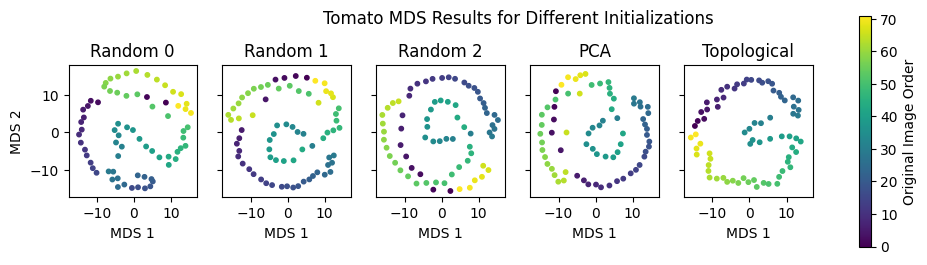

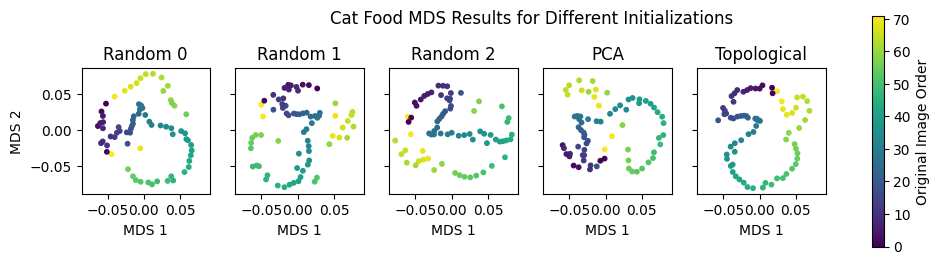

In [8]:
max_pdists = np.zeros(2)
bc1s = [] 
mds_stresses = np.zeros((2, 5))
mds_iters = np.zeros((2, 5))

for ex in range(2):

    object_number, example_name, metric = examples[ex]

    images = [read_image(object_number, index) for index in shuffled_image_indices] 
    image_data = np.vstack([image.flatten() for image in images]) 
    image_pdist = squareform(pdist(image_data, metric = metric))
    max_pdists[ex] = np.max(image_pdist)

    # get initializations 
    pca_coords = PCA(n_components = 2).fit_transform(image_data)
    top_init_coords, bc1, cycle_diameter = timds.get_top(image_pdist)
    bc1s += [bc1]

    # run mds  
    mds_algs = [MDS(n_components = 2, dissimilarity = 'precomputed', random_state = 0), 
                MDS(n_components = 2, dissimilarity = 'precomputed', random_state = 1), 
                MDS(n_components = 2, dissimilarity = 'precomputed', random_state = 2), 
                MDS(n_components = 2, dissimilarity = 'precomputed', n_init = 1),
                MDS(n_components = 2, dissimilarity = 'precomputed', n_init = 1)] 
    mds_coords = [mds_algs[0].fit_transform(image_pdist),
                  mds_algs[1].fit_transform(image_pdist),
                  mds_algs[2].fit_transform(image_pdist),
                  mds_algs[3].fit_transform(image_pdist, init = pca_coords),
                  mds_algs[4].fit_transform(image_pdist, init = top_init_coords)]  
    mds_stresses[ex, :] = [mds_algs[m].stress_ for m in range(5)]
    mds_iters[ex, :] = [mds_algs[m].n_iter_ for m in range(5)]

    # plot 
    fig, ax = plt.subplots(1, 5, figsize = (12, 3), sharex = True, sharey = True)
    for m in range(5): 
        cbar_plt = ax[m].scatter(mds_coords[m][:, 0], mds_coords[m][:, 1], s = 10, c = shuffled_image_indices) 
        ax[m].set_aspect('equal')
        ax[m].set_title(init_names[m])
        ax[m].set_xlabel('MDS 1') 
    ax[0].set_ylabel('MDS 2')
    cbar = plt.colorbar(cbar_plt, ax = ax)
    cbar.set_label('Original Image Order')
    plt.suptitle(example_name + ' MDS Results for Different Initializations', y = 0.9)  
    plt.show()

In [9]:
mds_stresses

array([[9.40416919e+04, 9.29456598e+04, 9.27317975e+04, 9.31762844e+04,
        9.58430247e+04],
       [1.11850027e+00, 1.20469214e+00, 1.19982291e+00, 1.11416734e+00,
        1.03640138e+00]])

In [10]:
mds_iters

array([[245., 199., 256.,  76.,  50.],
       [ 57.,  73.,  64.,  19.,  25.]])

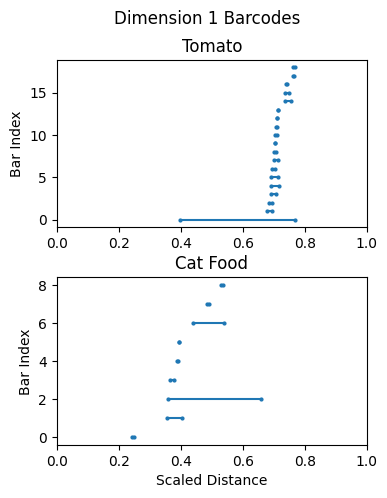

In [11]:
fig, ax = plt.subplots(2, 1, figsize = (4, 5))

for ex in range(2):

    bc1 = bc1s[ex] 
    bc1 = bc1.sort_values(by = 'birth', ignore_index = True) 
    bc1/=max_pdists[ex] 
    nbars = len(bc1)

    for bar_iter in range(nbars):
        ax[ex].plot(bc1.iloc[bar_iter], [bar_iter, bar_iter], color = 'tab:blue', marker = 'o', ms = 2)
    
    ax[ex].set_ylabel('Bar Index')
    ax[ex].set_title(examples[ex][1])
    ax[ex].set_xlim(0, 1)

ax[1].set_xlabel('Scaled Distance')

plt.subplots_adjust(hspace = 0.3)
plt.suptitle('Dimension 1 Barcodes')
plt.show()